In [ ]:
%pip -q install ncrystal

In [1]:
import NCrystal as NC
import openmc
import numpy as np
import matplotlib.pyplot as plt

In [2]:
openmc.config['cross_sections'] = '../data/endf-b7.1-hdf5/endfb-vii.1-hdf5/cross_sections.xml'

In [3]:
m1 = openmc.Material.from_ncrystal('Polyethylene_CH2.ncmat')

In [4]:
print(m1)

Material
	ID             =	1
	Name           =	
	Temperature    =	293.15
	Density        =	0.92 [g/cm3]
	Volume         =	None [cm^3]
	Depletable     =	False
	S(a,b) Tables  
	NCrystal conf  =	Polyethylene_CH2.ncmat
	Nuclides       
	H1             =	0.66656284   [ao]
	H2             =	0.00010382666666666666 [ao]
	C0             =	0.3333333333333333 [ao]



In [5]:
sphere = openmc.Sphere(r=50, boundary_type='vacuum')
cell1 = openmc.Cell(region=-sphere, fill=m1)
geom = openmc.Geometry([cell1])

In [6]:
source = openmc.IndependentSource()
source.energy = openmc.stats.Discrete([1e3], [1.0])

settings = openmc.Settings()
settings.source = source
settings.run_mode = 'fixed source'
settings.batches = 10
settings.particles = 10000

In [7]:
tally1 = openmc.Tally()
filter11 = openmc.CellFilter([cell1])
filter12 = openmc.EnergyFilter(np.geomspace(1e-4,10,1000))
tally1.scores = ['flux']
tally1.name = 'spectrum'
tally1.filters = [filter11, filter12]

tallies = openmc.Tallies([tally1])

In [8]:
model = openmc.model.Model(geometry=geom, settings=settings, tallies=tallies)

In [9]:
!rm summary.h5 statepoint.10.h5
model.run()

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

PosixPath('/home/marquezj/work/software/openmc-ncrystal/test/statepoint.10.h5')

In [10]:
sp = openmc.StatePoint('statepoint.10.h5')
tally = sp.get_tally(name='spectrum')

Text(0, 0.5, 'Integrated neutron fluence [n*cm]')

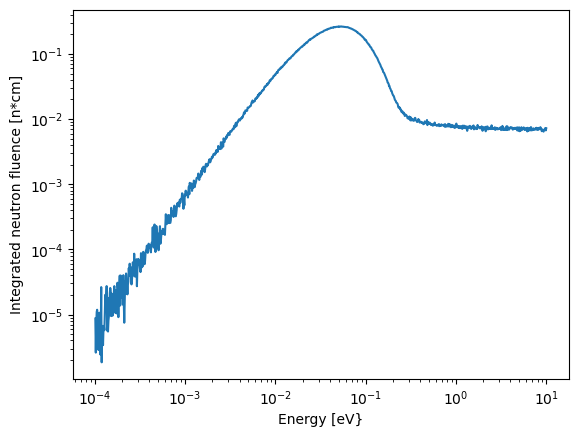

In [11]:
df = tally.get_pandas_dataframe()
phi_g = df['mean'].values
E_g = df['energy high [eV]'].values
plt.loglog(E_g, phi_g)
plt.xlabel('Energy [eV}')
plt.ylabel('Integrated neutron fluence [n*cm]')

In [12]:
!./ncrystal_ncmat2endf.py -n CH2 Polyethylene_CH2.ncmat -m '{"C":37, "H": 38}'

Get nuclear data...
Write ENDF file tsl_H_in_CH2.endf...
Write ENDF file tsl_C_in_CH2.endf...
Files created:
  tsl_H_in_CH2.endf
  tsl_C_in_CH2.endf


In [13]:
txt = r'''#!/usr/bin/env bash

echo 'H-1 XS from JEFF 3.3'
rm  n_0125_1-H-1.zip
wget --user-agent="Mozilla/5.0 (X11; Fedora; Linux x86_64; rv:52.0) Gecko/20100101 Firefox/52.0" https://www-nds.iaea.org/public/download-endf/JEFF-3.3/n/n_0125_1-H-1.zip
unzip -u n_0125_1-H-1.zip

ln -sf n_0125_1-H-1.dat tape20

ln -sf tsl_H_in_CH2.endf tape31

cat>input <<EOF
reconr
20 22
 'ENDF-6 tape for H-1 from JEFF-3.3'/
 125 3/
 .001/
 'ENDF-6 tape for H-1 from JEFF-3.3'/
 'Processed by the NJOY nuclear data processing system'/
 'see original JEFF-3.3 file for details of evaluation'/
 0/
broadr
20 22 23
125 1/
0.001/
293.6
0/
thermr
31 23 41
38 125 32 1 2 1 0 1 237  0 /
293.6 /
0.001 5.0/
acer
21 41 0 51 61 /
 2  1  1  .00  0 /
' Polyethylene'/
 125 293.6 poly 1 /
 1001 /
 237 200 238 1 1 5.0 1
acer / Plot ACE files 
0 51 62 62 63 64 / 
7 1 /
' Polyethylene'/
viewr / 
62 64 /
stop
stop
EOF

njoy < input

sed -i s/filename/"poly.ace"/g tape61
sed -i s/route/0/g tape61

mv tape51 poly.ace 
mv tape61 poly.xsdir 
mv output poly.out
mv tape64 mesi-005K.ps 
'''

with open('proc.njoy', 'w') as f:
    f.write(txt)
!chmod +x proc.njoy

In [14]:
!./proc.njoy

H-1 XS from JEFF 3.3
--2024-07-29 14:27:44--  https://www-nds.iaea.org/public/download-endf/JEFF-3.3/n/n_0125_1-H-1.zip
Resolving www-nds.iaea.org (www-nds.iaea.org)... 104.20.49.185, 172.67.17.137, 104.20.50.185, ...
Connecting to www-nds.iaea.org (www-nds.iaea.org)|104.20.49.185|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12665 (12K) [application/zip]
Saving to: ‘n_0125_1-H-1.zip’

n_0125_1-H-1.zip    100%[===================>]  12.37K  --.-KB/s    in 0.001s  

2024-07-29 14:27:47 (19.3 MB/s) - ‘n_0125_1-H-1.zip’ saved [12665/12665]

Archive:  n_0125_1-H-1.zip

 njoy 2016.76  03Jul24                                       07/29/24 14:27:47
 *****************************************************************************

 reconr...                                                                0.0s

 broadr...                                                                0.0s

 thermr...                                                                0.1s

 

In [15]:
!rm poly.h5
data = openmc.data.ThermalScattering.from_ace('poly.ace')
data.export_to_hdf5('poly.h5')

In [16]:
library = openmc.data.DataLibrary.from_xml(openmc.config['cross_sections'])
library.remove_by_material('H_in_CH2')
library.register_file('./poly.h5')
library.export_to_xml('./cross_sections.xml')

In [17]:
openmc.config['cross_sections'] = './cross_sections.xml'

In [18]:
m2 = openmc.Material()
m2.add_elements_from_formula('CH2')
m2.add_s_alpha_beta('c_H_in_CH2')
m2.set_density('g/cm3', 0.92)

In [19]:
print(m2)

Material
	ID             =	2
	Name           =	
	Temperature    =	None
	Density        =	0.92 [g/cm3]
	Volume         =	None [cm^3]
	Depletable     =	False
	S(a,b) Tables  
	S(a,b)         =	('c_H_in_CH2', 1.0)
	Nuclides       
	C0             =	0.3333333333333333 [ao]
	H1             =	0.66656284   [ao]
	H2             =	0.00010382666666666666 [ao]



In [20]:
sphere = openmc.Sphere(r=50, boundary_type='vacuum')
cell1 = openmc.Cell(region=-sphere, fill=m2)
geom = openmc.Geometry([cell1])

In [21]:
source = openmc.IndependentSource()
source.energy = openmc.stats.Discrete([1e3], [1.0])

settings = openmc.Settings()
settings.source = source
settings.run_mode = 'fixed source'
settings.batches = 10
settings.particles = 10000

In [22]:
tally1 = openmc.Tally()
filter11 = openmc.CellFilter([cell1])
filter12 = openmc.EnergyFilter(np.geomspace(1e-4,10,1000))
tally1.scores = ['flux']
tally1.name = 'spectrum'
tally1.filters = [filter11, filter12]

tallies = openmc.Tallies([tally1])

In [23]:
model = openmc.model.Model(geometry=geom, settings=settings, tallies=tallies)

In [24]:
!rm summary.h5 statepoint.10.h5
model.run()

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

PosixPath('/home/marquezj/work/software/openmc-ncrystal/test/statepoint.10.h5')

In [25]:
sp = openmc.StatePoint('statepoint.10.h5')
tally = sp.get_tally(name='spectrum')

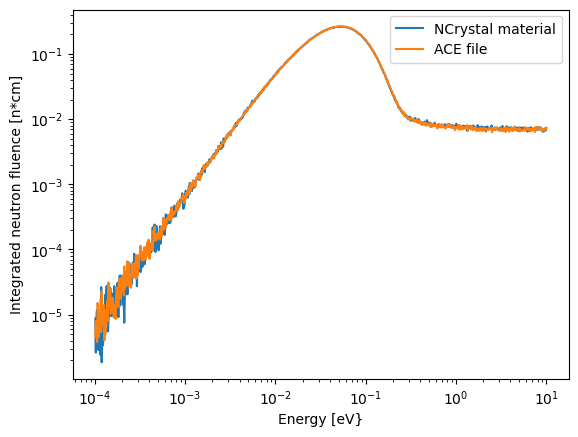

In [27]:
df = tally.get_pandas_dataframe()
phi_g2 = df['mean'].values
E_g2 = df['energy high [eV]'].values
plt.loglog(E_g, phi_g, label='NCrystal material')
plt.loglog(E_g2, phi_g2, label='ACE file')
plt.xlabel('Energy [eV}')
plt.ylabel('Integrated neutron fluence [n*cm]')
plt.legend()